Initializing NLP resources...


[nltk_data] Downloading package punkt to C:\Users\Shreyash
[nltk_data]     Pandey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Shreyash
[nltk_data]     Pandey\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to C:\Users\Shreyash
[nltk_data]     Pandey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Shreyash
[nltk_data]     Pandey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Shreyash
[nltk_data]     Pandey\AppData\Roaming\nltk_data...



STEP 1: LOADING DATA
Dataset Loaded Successfully. Shape: (17880, 18)

STEP 2: DATA PREPROCESSING
Merging columns: ['title', 'company_profile', 'description', 'requirements']
Applying advanced text cleaning... (This may take 30-60 seconds)
Preprocessing Complete. Processed Records: 17880

STEP 3: EXPLORATORY DATA ANALYSIS (EDA)


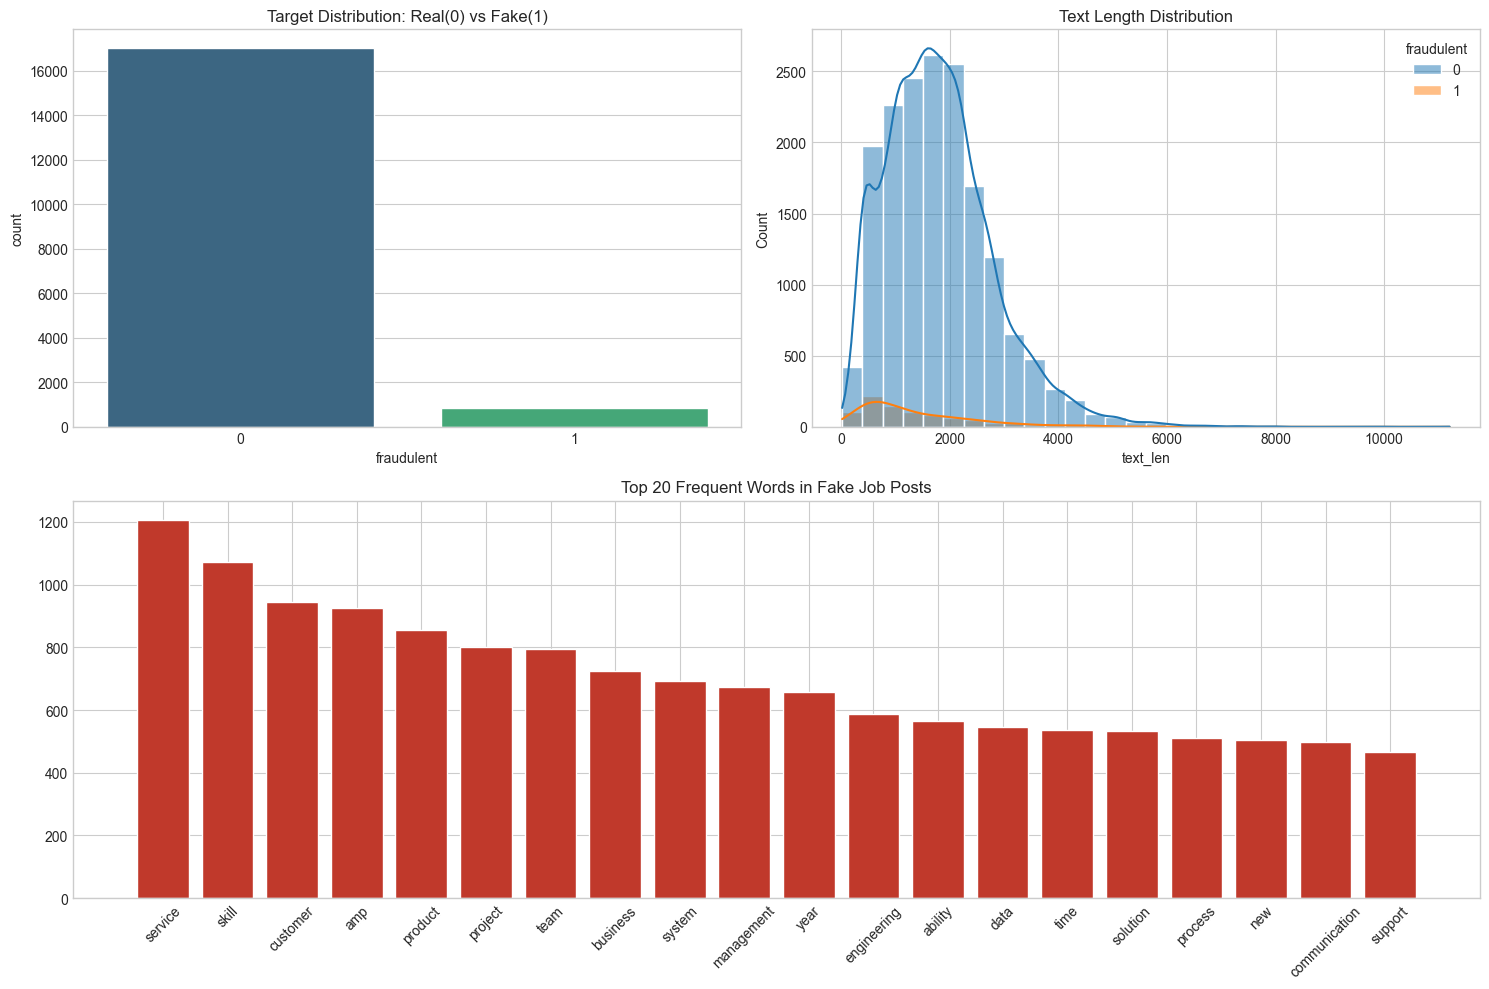

EDA Visualizations generated.

STEP 4: FEATURE EXTRACTION & SAVING
Generating TF-IDF Features (Max Features: 5000)...
Feature Matrix Created. Shape: (17880, 5000)
All artifacts saved successfully in 'processed_data/' directory.
Milestone 1 Completed Successfully.


In [14]:
"""
Milestone 1: Data Preprocessing & Exploration
Fake Job Post Detection System
"""

import pandas as pd
import numpy as np
import re
import os
import warnings
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Feature Extraction & Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Suppress warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# ---------------------------------------------------------
# FIX FOR LOOKUP ERROR
# ---------------------------------------------------------
print("Initializing NLP resources...")
try:
    # Downloading all necessary NLTK packages
    nltk.download('punkt')
    nltk.download('punkt_tab')  # FIX: Crucial for newer NLTK versions
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')    # Helper for lemmatization
except Exception as e:
    print(f"Warning: NLTK Download issue: {e}")

class FakeJobDataProcessor:
    """
    Data processing pipeline for Fake Job Post Detection System.
    Handles data loading, cleaning, EDA, and feature extraction.
    Prepared for Milestone 1 Submission.
    """
    
    def __init__(self, data_path='fake_job_postings.csv'):
        self.data_path = data_path
        self.df = None
        self.df_processed = None
        self.tfidf_vectorizer = None
        
        # Initialize NLP tools
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        # Domain specific stopwords to improve analysis
        self.stop_words.update({'job', 'work', 'company', 'position', 'apply', 'experience', 'candidate', 'role'})
    
    def load_data(self):
        """Step 1: Load Dataset"""
        print("\n" + "="*50)
        print("STEP 1: LOADING DATA")
        print("="*50)
        
        if os.path.exists(self.data_path):
            self.df = pd.read_csv(self.data_path)
            print(f"Dataset Loaded Successfully. Shape: {self.df.shape}")
        else:
            raise FileNotFoundError(f"Error: '{self.data_path}' not found. Please verify file name.")
        return self.df
    
    def clean_text(self, text):
        """Text Cleaning and Normalization Pipeline"""
        if pd.isna(text) or text == '':
            return ''
        
        # 1. Text Normalization
        text = str(text).lower()
        text = re.sub(r'<[^>]+>', '', text)       # HTML tags
        text = re.sub(r'http\S+', '', text)       # URLs
        text = re.sub(r'[^a-zA-Z\s]', '', text)   # Special characters
        
        # 2. Tokenization & Lemmatization
        try:
            tokens = word_tokenize(text)
        except LookupError:
            # Fallback if punkt_tab is missing despite download
            nltk.download('punkt_tab', quiet=True)
            tokens = word_tokenize(text)
            
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens 
                 if token not in self.stop_words and len(token) > 2]
        
        return ' '.join(tokens)

    def preprocess_data(self):
        """Step 2: Preprocessing and Text Merging"""
        print("\n" + "="*50)
        print("STEP 2: DATA PREPROCESSING")
        print("="*50)
        
        self.df_processed = self.df.copy()
        
        # Combine text columns for better context
        text_cols = ['title', 'company_profile', 'description', 'requirements']
        print(f"Merging columns: {text_cols}")
        
        self.df_processed['combined_text'] = self.df_processed[text_cols].fillna('').agg(' '.join, axis=1)
        
        print("Applying advanced text cleaning... (This may take 30-60 seconds)")
        self.df_processed['cleaned_text'] = self.df_processed['combined_text'].apply(self.clean_text)
        
        # Filter empty rows
        self.df_processed = self.df_processed[self.df_processed['cleaned_text'] != '']
        print(f"Preprocessing Complete. Processed Records: {len(self.df_processed)}")
        
        return self.df_processed

    def perform_eda(self):
        """Step 3: Exploratory Data Analysis"""
        print("\n" + "="*50)
        print("STEP 3: EXPLORATORY DATA ANALYSIS (EDA)")
        print("="*50)
        
        fig = plt.figure(figsize=(15, 10))
        
        # Plot 1: Target Distribution
        ax1 = fig.add_subplot(2, 2, 1)
        sns.countplot(x='fraudulent', data=self.df_processed, ax=ax1, palette='viridis')
        ax1.set_title('Target Distribution: Real(0) vs Fake(1)')
        
        # Plot 2: Text Length Analysis
        ax2 = fig.add_subplot(2, 2, 2)
        self.df_processed['text_len'] = self.df_processed['cleaned_text'].str.len()
        sns.histplot(data=self.df_processed, x='text_len', hue='fraudulent', bins=30, ax=ax2, kde=True)
        ax2.set_title('Text Length Distribution')
        
        # Plot 3: Top Words in Fake Jobs
        ax3 = fig.add_subplot(2, 1, 2)
        fake_text = ' '.join(self.df_processed[self.df_processed['fraudulent']==1]['cleaned_text'])
        common_fake = Counter(fake_text.split()).most_common(20)
        words, counts = zip(*common_fake)
        ax3.bar(words, counts, color='#c0392b')
        ax3.set_title('Top 20 Frequent Words in Fake Job Posts')
        ax3.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        print("EDA Visualizations generated.")

    def extract_features_and_save(self):
        """Step 4: Feature Extraction and Saving Artifacts"""
        print("\n" + "="*50)
        print("STEP 4: FEATURE EXTRACTION & SAVING")
        print("="*50)
        
        # TF-IDF Vectorization
        print("Generating TF-IDF Features (Max Features: 5000)...")
        self.tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
        X = self.tfidf_vectorizer.fit_transform(self.df_processed['cleaned_text'])
        y = self.df_processed['fraudulent'].values
        
        print(f"Feature Matrix Created. Shape: {X.shape}")
        
        # Splitting Data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
        
        # Save Artifacts
        output_dir = 'processed_data'
        os.makedirs(output_dir, exist_ok=True)
        
        # Save processed data
        self.df_processed.to_csv(f'{output_dir}/processed_jobs.csv', index=False)
        
        # Save arrays
        np.save(f'{output_dir}/y_train.npy', y_train)
        np.save(f'{output_dir}/y_test.npy', y_test)
        
        # Save Vectorizer (Crucial for Milestone 2)
        with open(f'{output_dir}/tfidf_vectorizer.pkl', 'wb') as f:
            pickle.dump(self.tfidf_vectorizer, f)
            
        print(f"All artifacts saved successfully in '{output_dir}/' directory.")
        print("Milestone 1 Completed Successfully.")

# -----------------------------------------------------------
# Execution
# -----------------------------------------------------------
if __name__ == "__main__":
    # Initialize and run pipeline
    processor = FakeJobDataProcessor('fake_job_postings.csv')
    
    processor.load_data()
    processor.preprocess_data()
    processor.perform_eda()
    processor.extract_features_and_save()